In [236]:
import warnings
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib.ticker import FormatStrFormatter, FuncFormatter

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import pmdarima
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from prophet import Prophet

In [76]:
# Отключаем предупреждения

warnings.filterwarnings("ignore")

In [77]:
# Загрузка данных

df = pd.read_csv('ВС DS Сбер data.csv', sep=';')
df.head()

,REPORTDATE,VALUE
0,30.12.2013,3457625638
1,31.12.2013,3417092149
2,01.01.2014,3417092149
3,02.01.2014,3417092149
4,03.01.2014,3417092149


# Анализ данных

In [78]:
# Вывод информации о данных

print('Количество дублирующих записей - ', len(df[df.duplicated()].values), '\n') 
df.info()

Количество дублирующих записей -  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   REPORTDATE  2111 non-null   object
 1   VALUE       2111 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB


In [79]:
# Дубли и пропуски в данных отсутствуют

In [80]:
# Преобразование формата данных временного ряда и сортировка по дате

df.REPORTDATE = pd.to_datetime(df.REPORTDATE, dayfirst=True)
df = df.sort_values('REPORTDATE', ascending=True)
df.head()

,REPORTDATE,VALUE
0,2013-12-30,3457625638
1,2013-12-31,3417092149
2,2014-01-01,3417092149
3,2014-01-02,3417092149
4,2014-01-03,3417092149


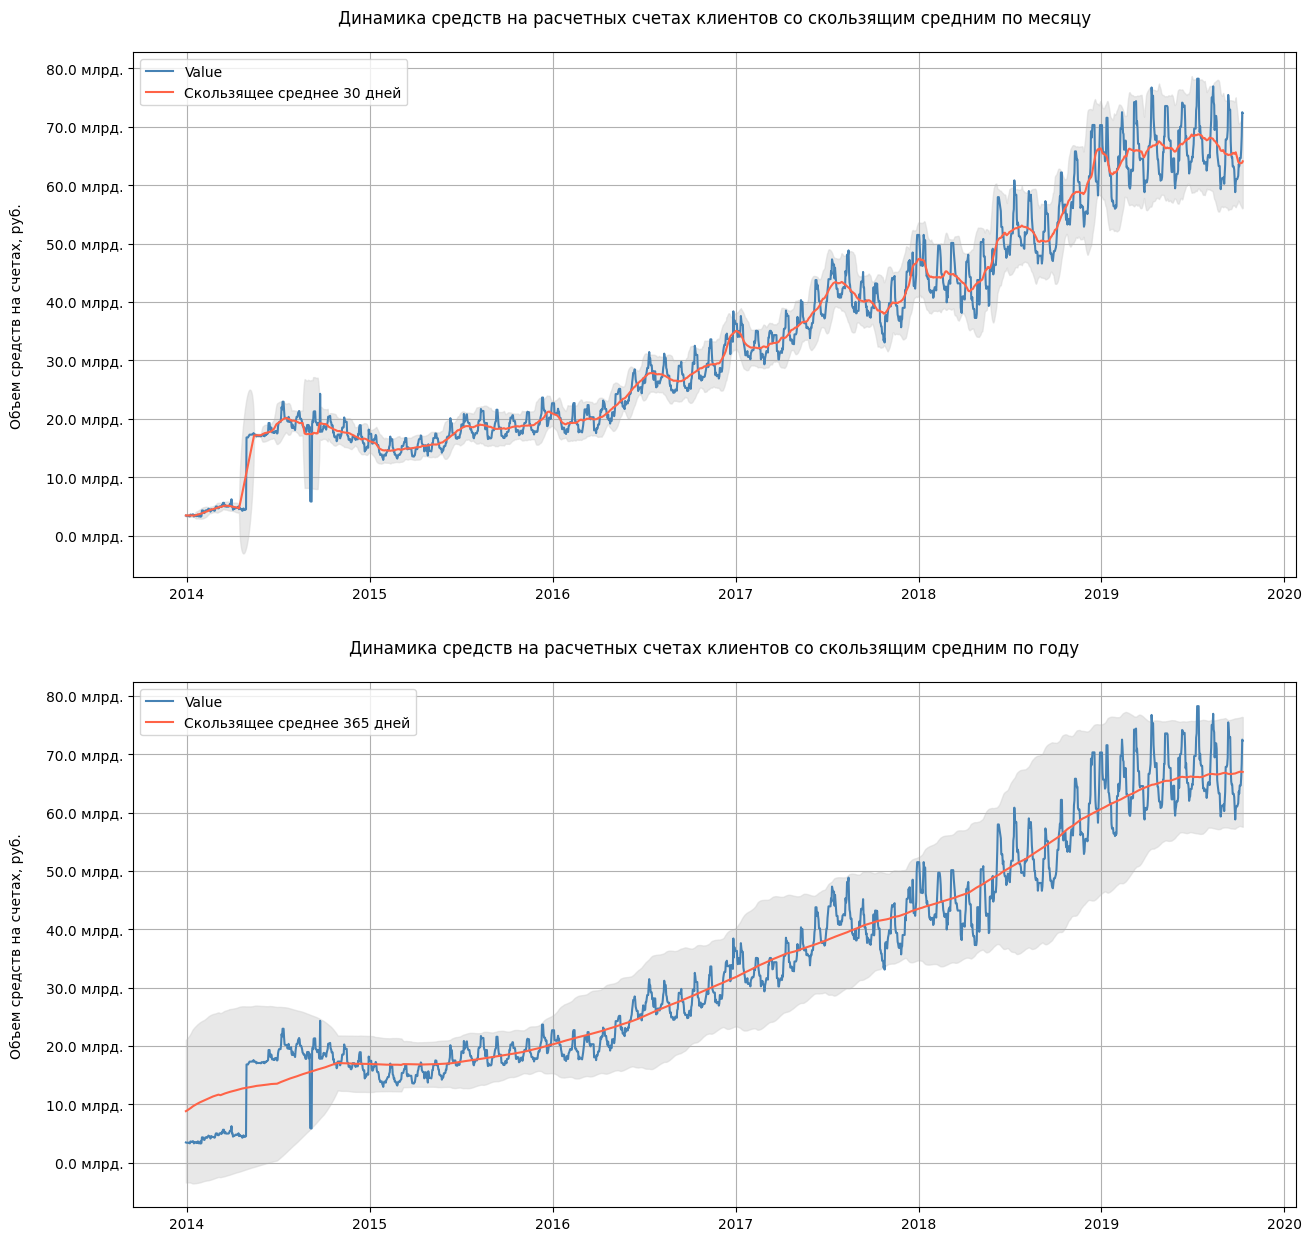

In [81]:
# Выводим графики средств на счетах клиентов, а также скользящее среднее с окном месяц и год и полосы Боллинджера с 
# доверительным 95%-м интервалом 

def billions(x, pos):
    return '%1.1f млрд.' % (x*1e-9)
formatter = FuncFormatter(billions)

ts = df.set_index('REPORTDATE').squeeze()
rolling_mean_month = ts.rolling(window=30, center=True, min_periods=15).mean()    
rolling_std_month = ts.rolling(window=30, center=True, min_periods=15).std()
lower_bound_month = rolling_mean_month - (1.96 * rolling_std_month)
upper_bound_month = rolling_mean_month + (1.96 * rolling_std_month)

rolling_mean_year = ts.rolling(window=365, center=True, min_periods=182).mean()    
rolling_std_year = ts.rolling(window=365, center=True, min_periods=182).std()
lower_bound_year = rolling_mean_year - (1.96 * rolling_std_year)
upper_bound_year = rolling_mean_year + (1.96 * rolling_std_year)

fig, ax = plt.subplots(2, 1, figsize=(15, 15))

ax[0].plot(ts, label='Value', color='steelblue')
ax[0].plot(rolling_mean_month, 'g', label='Скользящее среднее 30 дней', color='tomato')
ax[0].fill_between(x=ts.index, y1=lower_bound_month, y2=upper_bound_month, color='lightgrey', alpha=0.5)
ax[0].legend(loc='upper left')
ax[0].set_title('Динамика средств на расчетных счетах клиентов со скользящим средним по месяцу\n')
ax[0].set_ylabel('Объем средств на счетах, руб.\n')
ax[0].xaxis.set_major_locator(dates.AutoDateLocator())  
ax[0].yaxis.set_major_formatter(formatter)
ax[0].grid()

ax[1].plot(ts, label='Value', color='steelblue')
ax[1].plot(rolling_mean_year, 'g', label='Скользящее среднее 365 дней', color='tomato')
ax[1].fill_between(x=ts.index, y1=lower_bound_year, y2=upper_bound_year, color='lightgrey', alpha=0.5)
ax[1].legend(loc='upper left')
ax[1].set_title('Динамика средств на расчетных счетах клиентов со скользящим средним по году\n')
ax[1].set_ylabel('Объем средств на счетах, руб.\n')
ax[1].xaxis.set_major_locator(dates.AutoDateLocator())
ax[1].yaxis.set_major_formatter(formatter)
ax[1].grid();

In [82]:
# Исключаем данные, выбивающиеся из общей тенденции, которые могут негативно сказаться на результатах прогноза модели.
# Для построения модели используем данные с 01.01.2015 по 31.09.2019, для удобства перенесем данные в Pandas Time Series

df = df.loc[367:2100, :].reset_index(drop=True)
ts = df.set_index('REPORTDATE').squeeze().rename('VALUE')

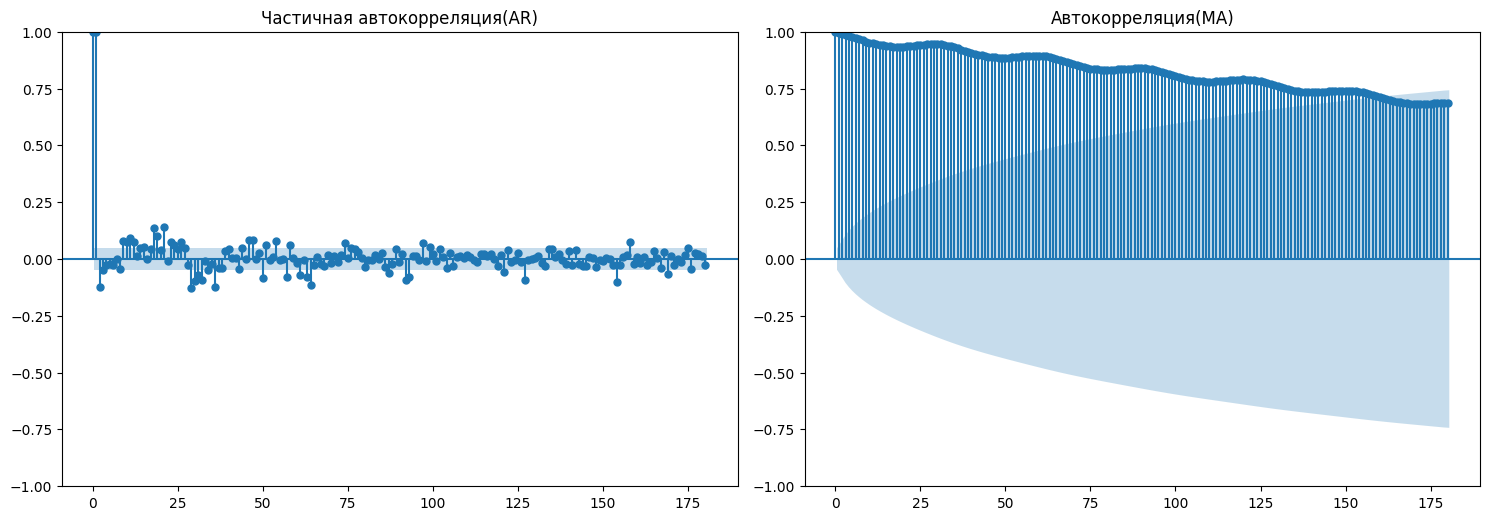

In [83]:
# Вывод графиков автокорреляции и частичной автокорреляции 

fig = plt.figure(figsize=(15,10))
ax_1 = plt.subplot2grid(shape=(2,2), loc=(1,0))
ax_2 = plt.subplot2grid(shape=(2,2), loc=(1,1))
smt.graphics.plot_pacf(ts, ax=ax_1, lags=180, title='Частичная автокорреляция(AR)')
smt.graphics.plot_acf(ts, ax=ax_2, lags=180, title='Автокорреляция(MA)');
plt.tight_layout()
plt.show();       

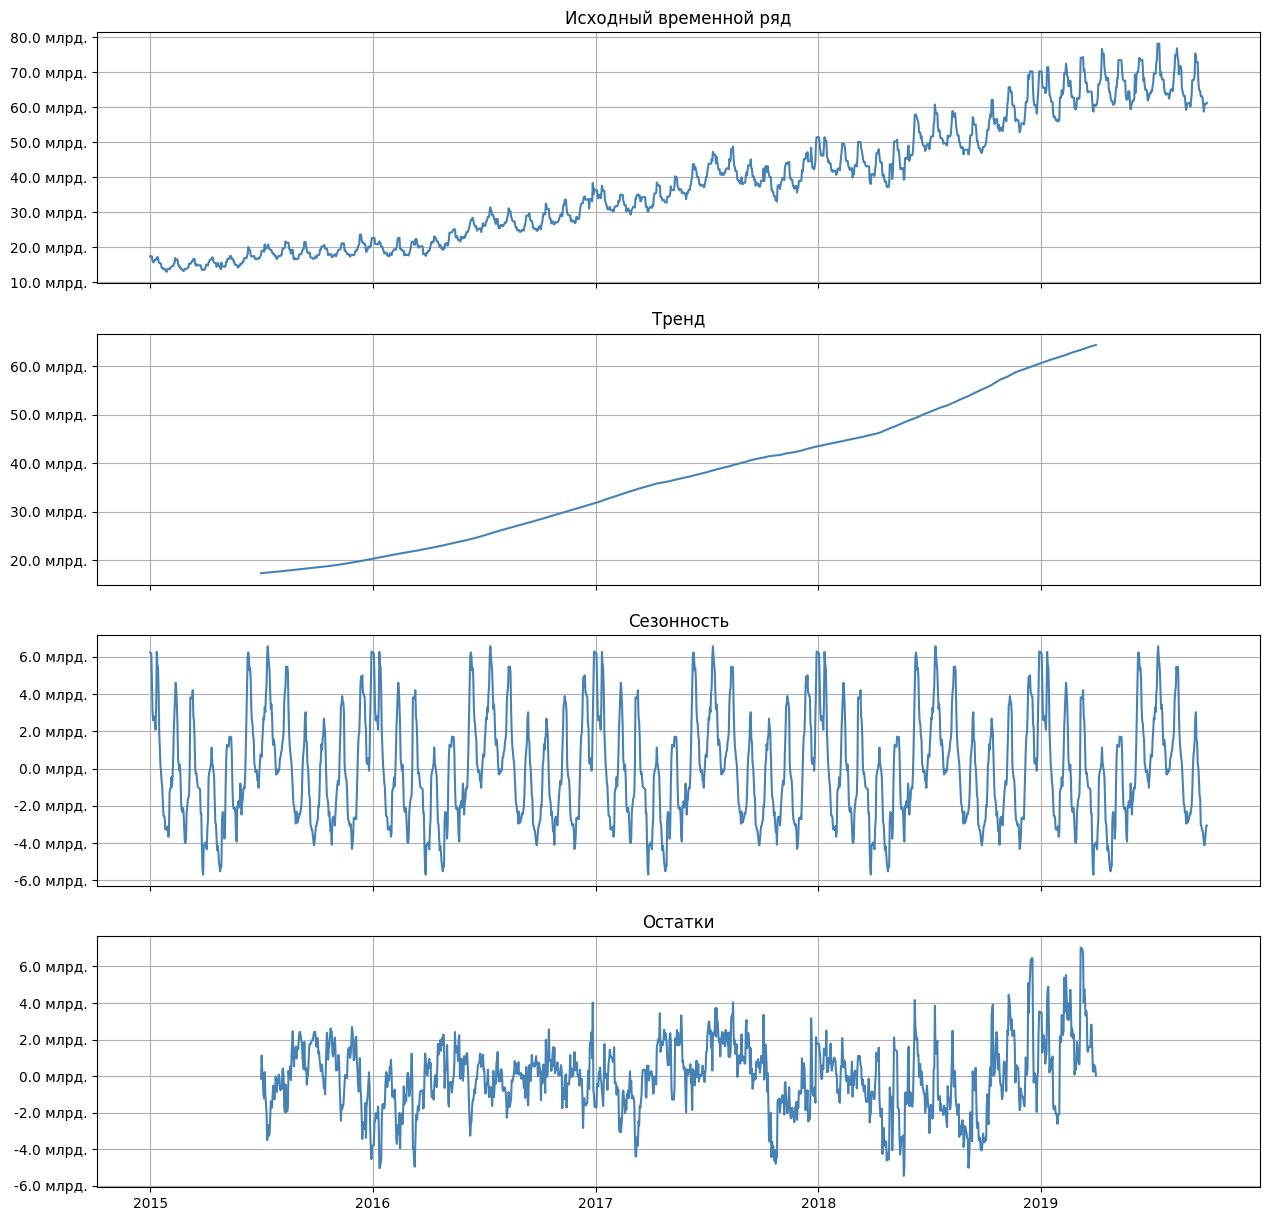

In [84]:
# Сделаем декомпозицию и построим график тренда, сезонности и остатков

decomposed_data = smt.seasonal_decompose(ts, period=365)
trend = decomposed_data.trend
seasonal = decomposed_data.seasonal
residual = decomposed_data.resid 

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(15, 15))
ax[0].plot(ts, color='steelblue')
ax[0].set_title('Исходный временной ряд')
ax[0].grid(True) 
ax[0].yaxis.set_major_formatter(formatter)

ax[1].plot(trend, color='steelblue')
ax[1].set_title('Тренд')
ax[1].grid(True) 
ax[1].yaxis.set_major_formatter(formatter)

ax[2].plot(seasonal, color='steelblue')
ax[2].set_title('Сезонность')
ax[2].grid(True)  
ax[2].yaxis.set_major_formatter(formatter)

ax[3].plot(residual, color='steelblue')
ax[3].set_title('Остатки')
ax[3].grid(True)
ax[3].yaxis.set_major_formatter(formatter)
ax[3].xaxis.set_major_locator(dates.AutoDateLocator())

In [85]:
# Проверка ряда на стационарность с помощью теста Дики-Фуллера

p = sm.tsa.stattools.adfuller(ts, maxlag=30, regression='ct', autolag="AIC")[1]
conclusion = " стационарный" if p < 0.05 else " нестационарный"
print(f'Тест Дики-Фуллера 95% при maxlag=30: ряд{conclusion} (p-value: {round(p, 3)})')
p = sm.tsa.stattools.adfuller(ts, maxlag=365, regression='ct', autolag="AIC")[1]
conclusion = " стационарный" if p < 0.05 else " нестационарный"
print(f'Тест Дики-Фуллера 95% при maxlag=365: ряд{conclusion} (p-value: {round(p, 3)})')

Тест Дики-Фуллера 95% при maxlag=30: ряд нестационарный (p-value: 0.252)
Тест Дики-Фуллера 95% при maxlag=365: ряд нестационарный (p-value: 0.16)


In [86]:
# Как видим из графиков, во временном ряду присутствует тренд и сезонная компонента с периодом 30(+1) дней (график 
# автокорреляции) и 365 дней с пиками в январе и июне-июле. По тесту Дики-Фуллера, ряд не является стационарным. 
# Учтем это при построении моделей.

# Построение моделей 

In [197]:
# Разделение на тренировочную и тестовую выборки

split_index = df[df.iloc[:,0]=='2019-01-01'].index[0]

ts_train = ts.head(split_index)
ts_test = ts.tail(len(ts)-split_index)

In [198]:
# Создаем функцию для оценки модели и построения ее графиков

def model_evaluation(data, title):
    # Расчет метрик модели на тестовой выборке
    mae = mean_absolute_error(data['value'].tail(len(ts)-split_index), data['forecast'].tail(len(ts)-split_index))
    mape = mean_absolute_percentage_error(data['value'].tail(len(ts)-split_index), data['forecast'].tail(len(ts)-split_index))
    rmse = mean_squared_error(data['value'].tail(len(ts)-split_index), data['forecast'].tail(len(ts)-split_index), squared=False)
    # Рассчитываем пробитие на тестовой выборке
    data['penetration'] = data['forecast'].tail(len(ts)-split_index).min() - data['value'].tail(len(ts)-split_index)
    data['forecast_stable_part'] = data['forecast'].tail(len(ts)-split_index).min()
    data['real_stable_part'] = data['value'].tail(len(ts)-split_index).min()
    penetration = data.penetration[data.penetration > 0].sum()
    # Построение графиков прогноза
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(2,1, 1)
    ax2 = fig.add_subplot(2,1, 2)
    ## График модели на тренировочных данных
    data[['value','forecast']].head(split_index).plot(color=['black','green'], title='Модель '+title, grid=True, ax=ax1)      
    ax1.set(xlabel=None)
    ## График прогноза на тестовых данных
    data[['value','forecast', 'forecast_stable_part', 'real_stable_part']].tail(len(ts)-split_index).\
    plot(color=['black','red', 'orange', 'green'], title='Прогноз на тестовой выборке', grid=True, ax=ax2)
    ax2.set(xlabel=None)
    ax2.legend(loc='upper left')
    formatter = FuncFormatter(billions)
    ax1.yaxis.set_major_formatter(formatter)
    ax2.yaxis.set_major_formatter(formatter)
    plt.show()

    print(f'Значения метрик модели --> MAE - {np.round(mae)} | MAPE - {np.round(mape*100)}% | RMSE - {np.round(rmse)}')
    print(f'Объем пробития прогнозной стабильной части --> {penetration}')

### SARIMA

In [50]:
# Подбор параметров для модели SARIMAX из библиотеки statsmodel

params = pmdarima.auto_arima(ts, exogenous=None, seasonal=True, stationary=False, m=30, information_criterion='aic', \
         max_order=12, max_p=3, max_q=3, max_P=3, max_Q=3, error_action='ignore')
print(f'Best parameters:\n(p, d, q): {params.order} and  (P, D, Q, s): {params.seasonal_order}')

Best parameters:
(p, d, q): (3, 0, 1) and  (P, D, Q, s): (2, 1, 0, 30)


In [199]:
# Обучаем модель

sarima = smt.SARIMAX(ts_train, order=(3,0,1), 
                     seasonal_order=(2,1,0,30), 
                     enforce_invertibility=False,
                     exog=None).fit()

In [200]:
# Получаем прогноз для тестовых данных

df_srm_test = ts_test.to_frame(name='value')
df_srm_test['forecast'] = sarima.predict(start=len(ts_train), end=len(ts_train)+len(ts_test)-1, exog=None)

In [201]:
# Поместим результаты и исходные данные в отдельный датафрейм для вывода графиков и метрик

df_srm_train = ts_train.to_frame(name='value')
df_srm_train['forecast'] = sarima.fittedvalues
df_srm = df_srm_train.append(df_srm_test)

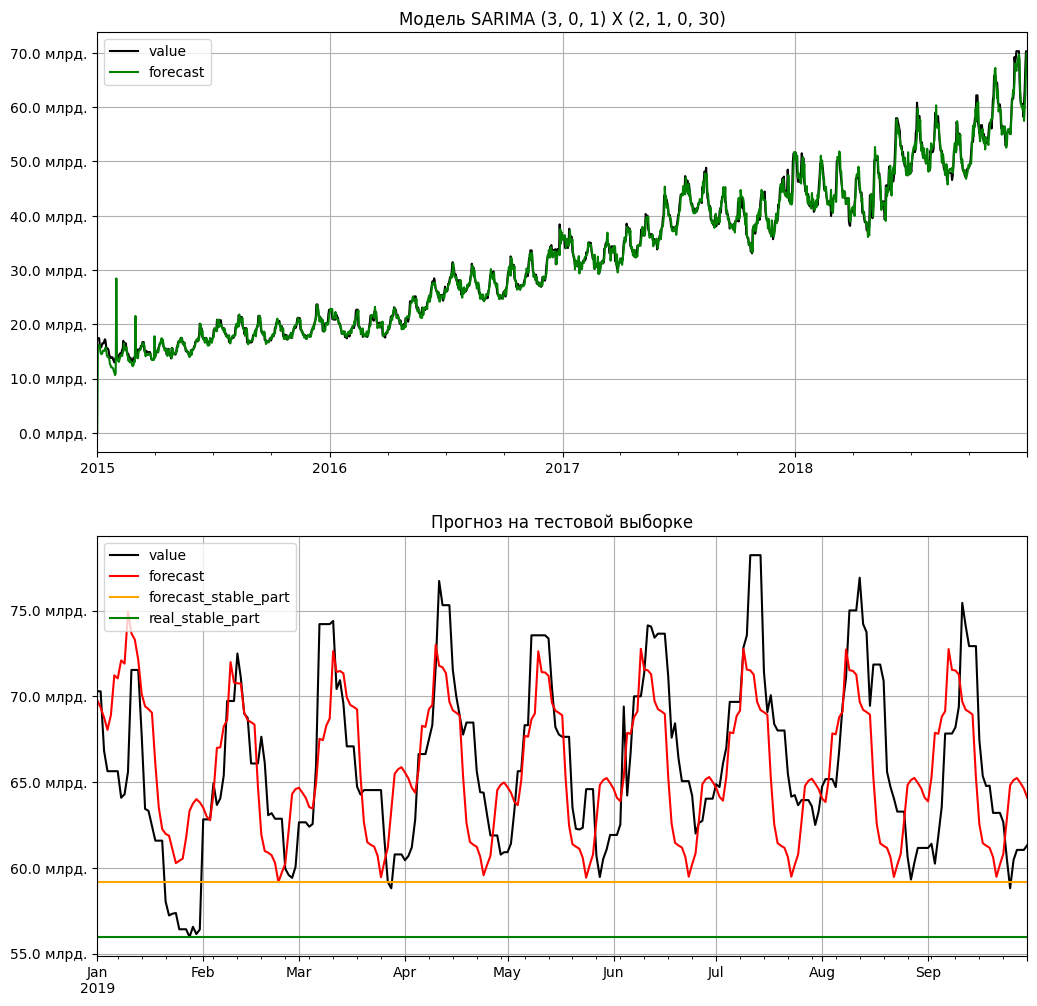

Значения метрик модели --> MAE - 3289422109.0 | MAPE - 5.0% | RMSE - 3934484021.0
Объем пробития прогнозной стабильной части --> 27263734184.089012


In [202]:
model_evaluation(df_srm, title='SARIMA (3, 0, 1) X (2, 1, 0, 30)')

In [ ]:
# Как видим, SARIMA показывает довольно высокую точность по метрикам и минимальное пробитие на горизонте 1 - 8 месяцев, при этом
# есть значительное пробитие в январе. На исходном графике исторических данных видно, что такое снижение средств на счетах 
# клиентов, как в январе 2019г. несколько аномально, по сравнению с предыдущими годами, поэтому в целом качество предсказания 
# модели можно считать высоким.

### Prophet

In [203]:
# Подготавливаем тренировочные и тестовые данные

df_train = ts_train.reset_index().rename(columns={'REPORTDATE':'ds', 'VALUE':'y'})
df_test = ts_test.reset_index().rename(columns={'REPORTDATE':'ds', 'VALUE':'y'})

In [204]:
# Обучаем модель на тренировочных данных

prophet = Prophet(growth='linear', changepoints=None, 
                  n_changepoints=365,
                  seasonality_mode='multiplicative',
                  yearly_seasonality='auto', 
                  weekly_seasonality='auto', 
                  daily_seasonality=False,
                  holidays=None)
prophet.add_country_holidays(country_name='RU')
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=3)

prophet.fit(df_train)

13:16:16 - cmdstanpy - INFO - Chain [1] start processing
13:16:18 - cmdstanpy - INFO - Chain [1] done processing


In [205]:
# Получаем прогноз для тестовых данных

df_prophet = prophet.make_future_dataframe(periods=len(df_test), freq='D', include_history=True)
df_prophet = prophet.predict(df_prophet)

In [206]:
# Поместим результаты в отдельный датафрейм

df_prt_train = df_train.merge(df_prophet[['ds','yhat']], how='left').\
               rename(columns={'yhat':'forecast', 'y':'value'}).set_index('ds')
df_prt_test = df_test.merge(df_prophet[['ds','yhat']], how='left').\
              rename(columns={'yhat':'forecast', 'y':'value'}).set_index('ds')
df_prophet_unit = df_prt_train.append(df_prt_test)

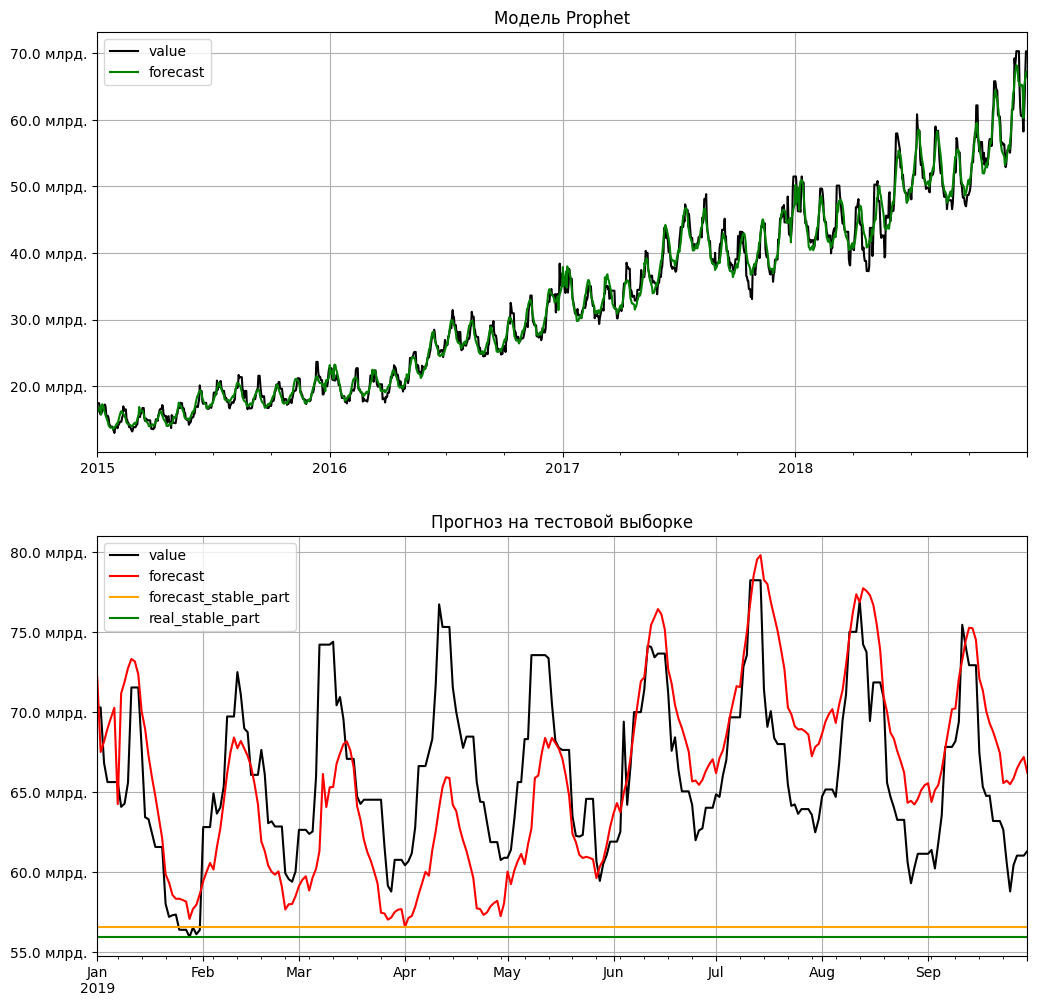

Значения метрик модели --> MAE - 3594000077.0 | MAPE - 5.0% | RMSE - 4342594487.0
Объем пробития прогнозной стабильной части --> 1805276764.518982


In [207]:
model_evaluation(df_prophet_unit, title='Prophet')

In [ ]:
# Как видим, Prophet показывает более высокие значения MAE и RMSE, при этом объем пробития на горизонте 5 и более месяцев \
# минимальный и довольно высокий на горизонте 1-4  месяцев от 01.01.2019г, что плохо скажется на краткосрочном прогнозе.
# Остановимся на модели SARIMA.

### Построение функции для прогнозирования стабильной части для заданной даты и горизонта

In [430]:
# Создадим функцию для прогноза объема стабильной части средств с заданным горизонтом n месяцев от указанной даты
# На вход подаются дата, горизонт прогноза и исторические данные, на выходе функция выводит прогноз стабильной части и 
# (по запросу) объем пробития и разницы фактической и модельной стабильной части, для этого использован параметр fault(boolean).
# Он указывает, выводить ли объем пробития и разницу фактической и модельной стабильной части.

def prediction(hist_data, start_date, horizon, fault):
    #hist_data.REPORTDATE = pd.to_datetime(hist_data.REPORTDATE)
    # Выделение из ряда обучающей выборки до указанной даты
    start_date = pd.to_datetime(start_date)
    last_date = start_date + relativedelta(months=int(horizon[:-1]))
    split_index = hist_data[hist_data.loc[:,'REPORTDATE']==start_date].index[0]
    ts_hist = hist_data.set_index('REPORTDATE').squeeze().rename('VALUE').head(split_index)
    df_test = pd.DataFrame(pd.date_range(start_date, last_date), columns=['REPORTDATE'])
    # Обучение модели
    sarima = smt.SARIMAX(ts_hist, order=(3,0,1), 
                         seasonal_order=(2,1,0,30), 
                         enforce_invertibility=False,
                         exog=None).fit()
    # Прогноз
    predict = sarima.predict(start=len(ts_hist), end=len(ts_hist)+len(df_test)-1, exog=None)
    # Расчет стабильной части
    stable_part=round(min(predict), 2)
    print(f'Стабильная часть средств на дату {str(start_date)[:10]} с горизонтом\
    {int(horizon[:-1])} месяц(-а,-ев) - {stable_part}')
    # Расчет объема пробития, если указанный интервал start_data + N месяцев находится в пределах исторических данных, а также 
    # разницы между фактической и модельной стабильной частью
    if (fault == True) and ((hist_data.loc[len(hist_data) - 1, 'REPORTDATE'] - last_date).days >= 0):
        df_test['forecast'] = predict.tolist()
        df_test = pd.merge(left=hist_data, right=df_test, on='REPORTDATE', how='inner') 
        df_test['penetration'] = df_test['forecast'].min() - df_test['VALUE']
        penetration = round(df_test.penetration[df_test.penetration > 0].sum(), 2)
        print(f'Объем пробития стабильной части - {penetration}')
        delta = round(df_test['VALUE'].min() - df_test['forecast'].min(), 2)
        print(f'Дельта между фактической и модельной стабильной частью - {delta if delta > 0 else 0}') 
    elif (fault == True) and ((hist_data.loc[len(hist_data) - 1, 'REPORTDATE'] - last_date).days < 0):
        print('Объем пробития стабильной части и дельта между фактической и модельной стабильной частью неизвестны.')
        print('Прогноз вне диапазона исторических данных.')
    else:
        None

In [413]:
# Проверим модель на различных датах и горизонтах 

prediction(df, start_date='2019-03-01', horizon='3M', fault=True)

Стабильная часть средств на дату 2019-03-01 с горизонтом 3 месяц(-а,-ев) - 58789617340.9
Объем пробития стабильной части - 0.0
Дельта между фактической и модельной стабильной частью - 10463706.1


In [414]:
prediction(df, start_date='2019-01-01', horizon='6M', fault=True)

Стабильная часть средств на дату 2019-01-01 с горизонтом 6 месяц(-а,-ев) - 59163178931.93
Объем пробития стабильной части - 26906849640.16
Дельта между фактической и модельной стабильной частью - 0


In [415]:
prediction(df, start_date='2019-06-01', horizon='1M', fault=True)

Стабильная часть средств на дату 2019-06-01 с горизонтом 1 месяц(-а,-ев) - 60654391991.0
Объем пробития стабильной части - 0.0
Дельта между фактической и модельной стабильной частью - 1260554309.0


In [431]:
prediction(df, start_date='2019-05-01', horizon='12M', fault=True)

Стабильная часть средств на дату 2019-05-01 с горизонтом    12 месяц(-а,-ев) - 60277681466.69
Объем пробития стабильной части и дельта между фактической и модельной стабильной частью неизвестны.
Прогноз вне диапазона исторических данных.


In [423]:
prediction(df, start_date='2019-04-01', horizon='9M', fault=False)

Стабильная часть средств на дату 2019-04-01 с горизонтом 9 месяц(-а,-ев) - 58195204569.75
